In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np

from src.camera import Camera
from src.image_processing_pipeline import ImageProcessingPipeline

In [2]:
camera = Camera.create("camera_cal/calibration*.jpg")
camera.calibrate(load=True)

Text(0.5, 1.0, 'Undistorted Image')

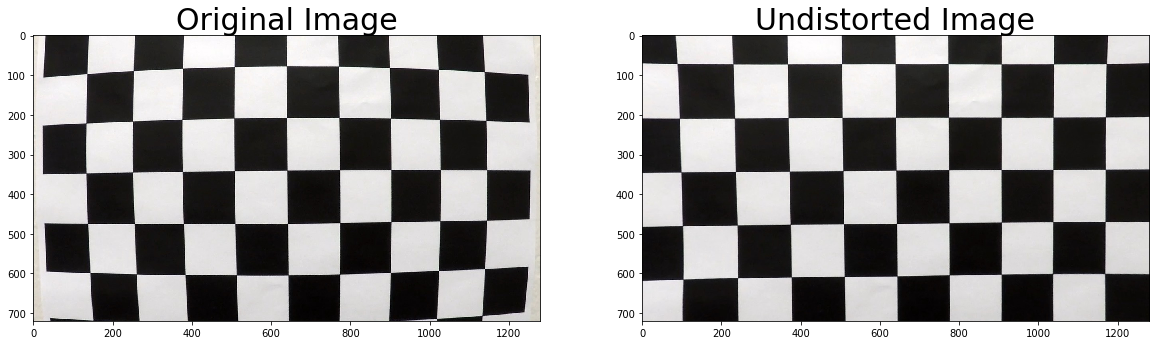

In [3]:
distorted_image = cv2.cvtColor(cv2.imread("camera_cal/calibration1.jpg"), cv2.COLOR_BGR2RGB)
undistorted_image = camera.undistort(distorted_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Undistorted Image')

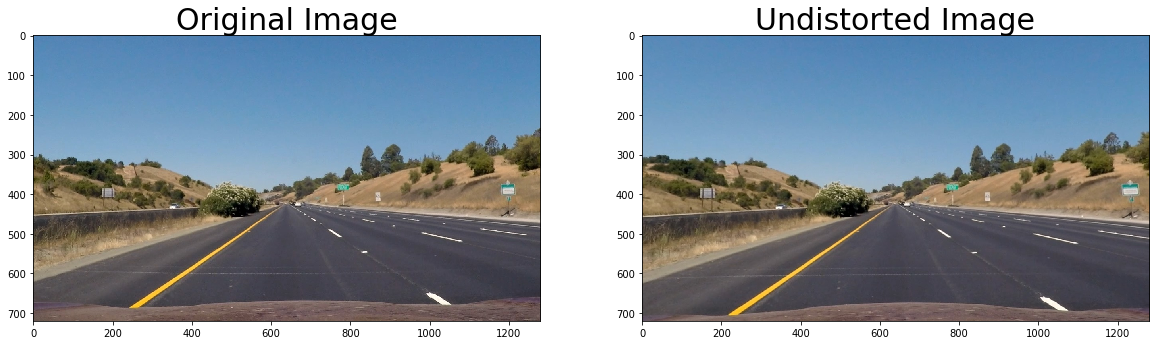

In [4]:
distorted_image = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
undistorted_image = camera.undistort(distorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)

True

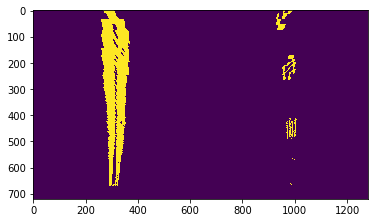

In [5]:
pipeline = ImageProcessingPipeline(camera)

processed = pipeline.process(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))

pipeline.sobel_thresh = (10, 120)
pipeline.sobel_kernel = 3
pipeline.mag_thresh = (20, 200)
pipeline.dir_thresh = (np.pi / 4, np.pi)
pipeline.color_thresh = (0, 255)

pipeline.yellow_lower = [15, 100, 0]
pipeline.yellow_upper = [50, 220, 255]

pipeline.white_lower = [0, 200, 0]
pipeline.white_upper = [255, 255, 255]

pipeline.lane_points = np.float32([[210,720],[595,450],[690,450], [1110, 720]])
pipeline.lane_dest_points = np.float32([[200, 720], [200, 0], [1000, 0], [1000, 720]])

thresholded_warped_image, undistorted = pipeline.process(distorted_image)
plt.imshow(thresholded_warped_image)
cv2.imwrite("./output_images/straight_lines1.jpg", pipeline._warp_image(distorted_image))

Text(0.5, 1.0, 'Undistorted Image')

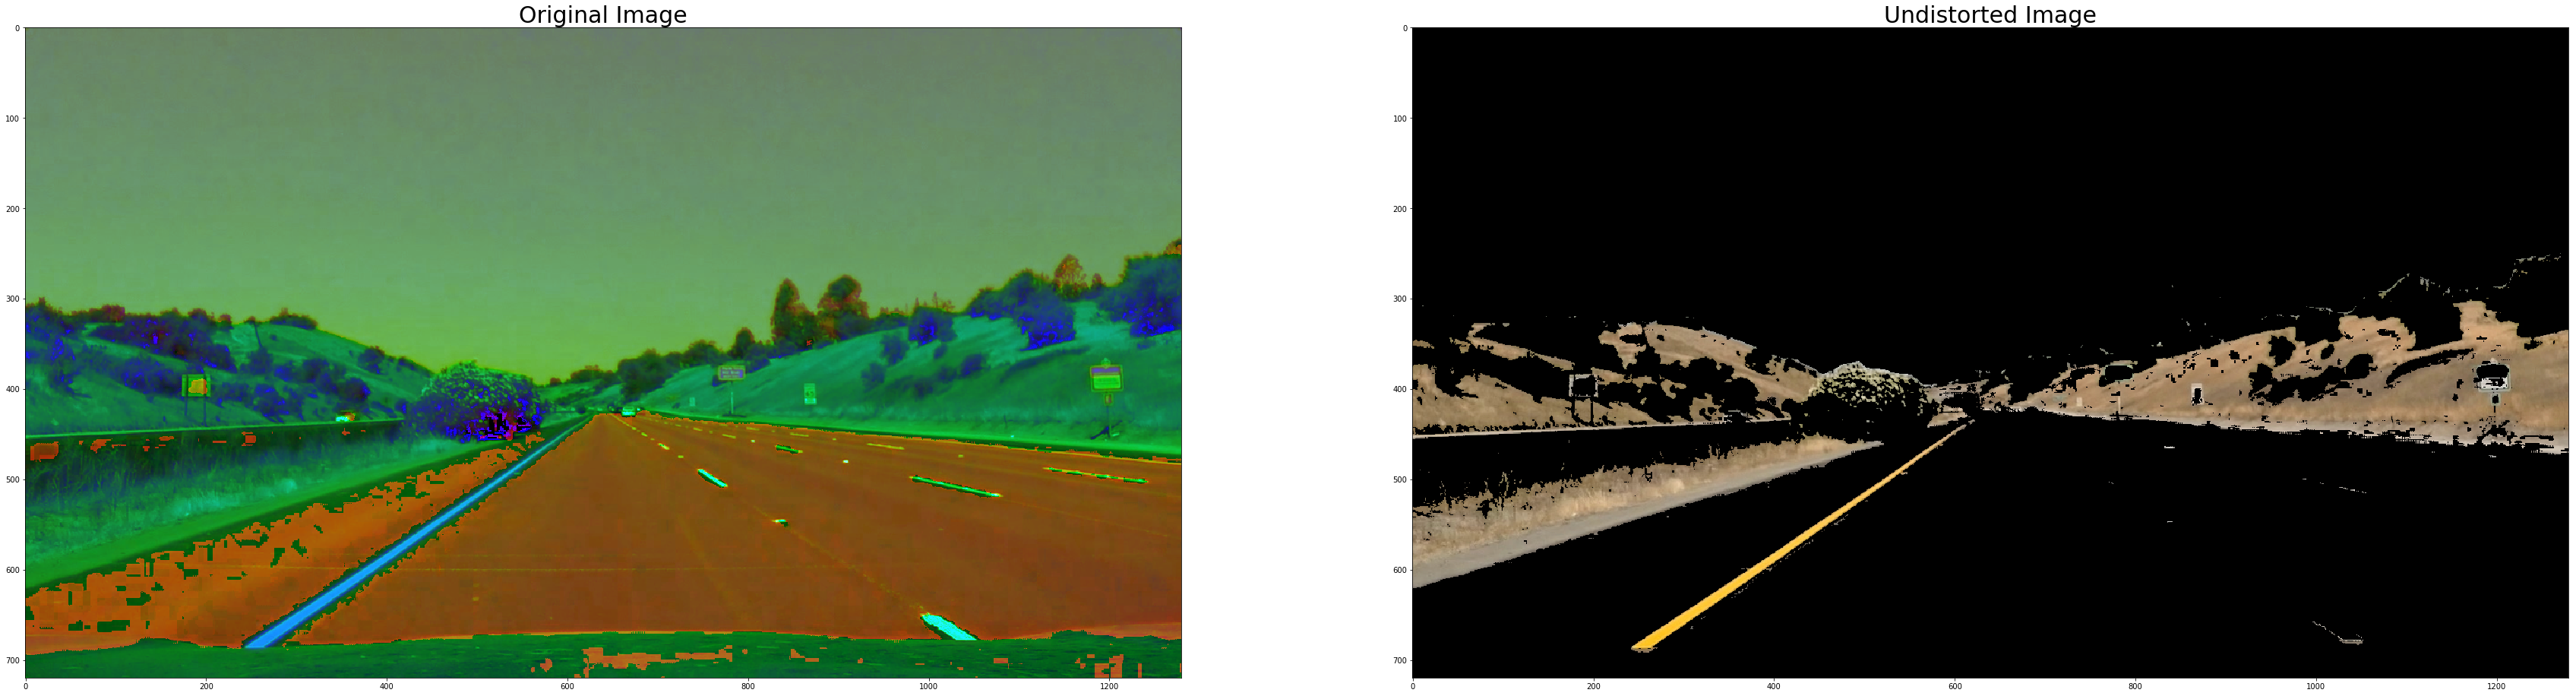

In [6]:
#plt.imshow(pipeline._color_pipeline(cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB)))

image = cv2.cvtColor(distorted_image, cv2.COLOR_RGB2HLS)
out = cv2.inRange(image, np.array(pipeline.yellow_lower), np.array(pipeline.yellow_upper))
yellow = cv2.bitwise_and(image, image, mask=out)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(yellow, cv2.COLOR_HLS2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Undistorted Image')

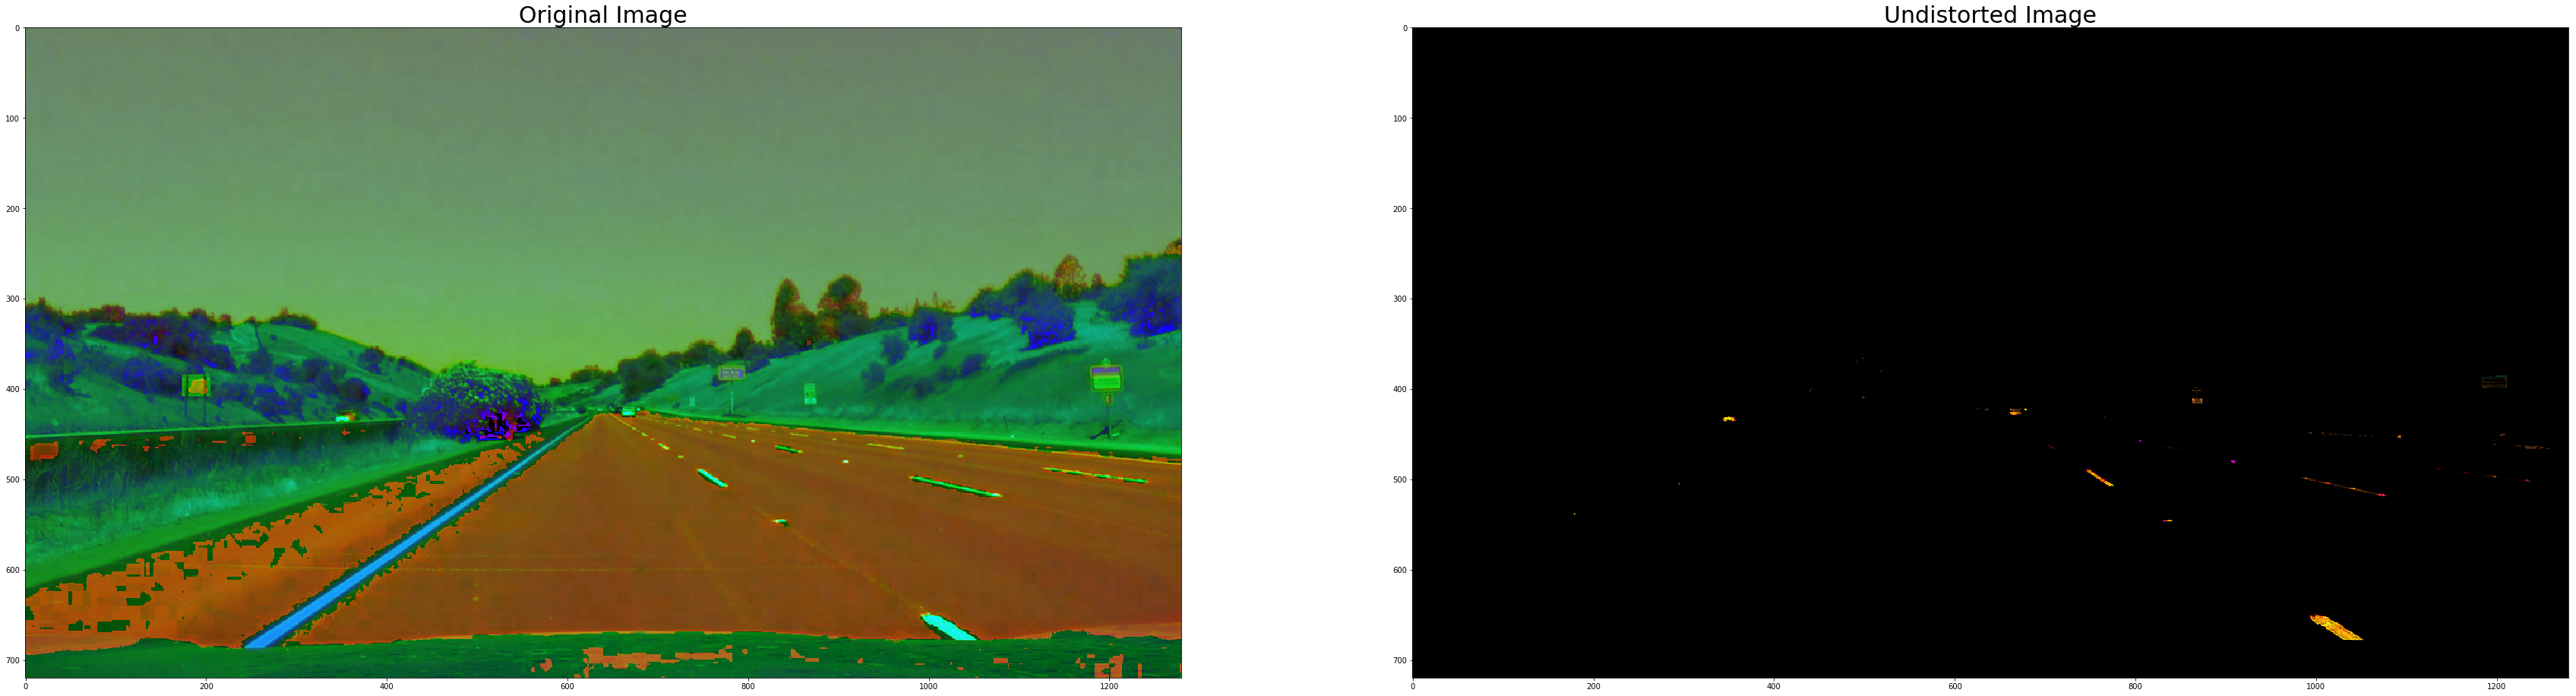

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
out = cv2.inRange(image, np.array(pipeline.white_lower), np.array(pipeline.white_upper))
white = cv2.bitwise_and(image, image, mask=out)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(white, cv2.COLOR_HSV2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

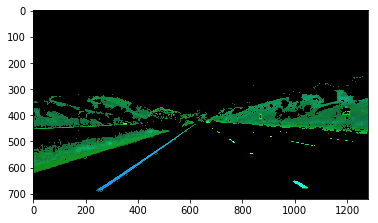

In [8]:
plt.imshow(cv2.bitwise_or(yellow, white))

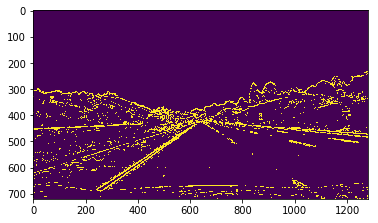

In [9]:
plt.imshow(pipeline._combine(image))

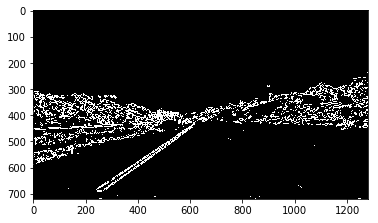

In [10]:
before_warped = pipeline._combine(pipeline._color_pipeline(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
plt.imshow(before_warped, cmap='gray')

Text(0.5, 1.0, 'Undistorted Image')

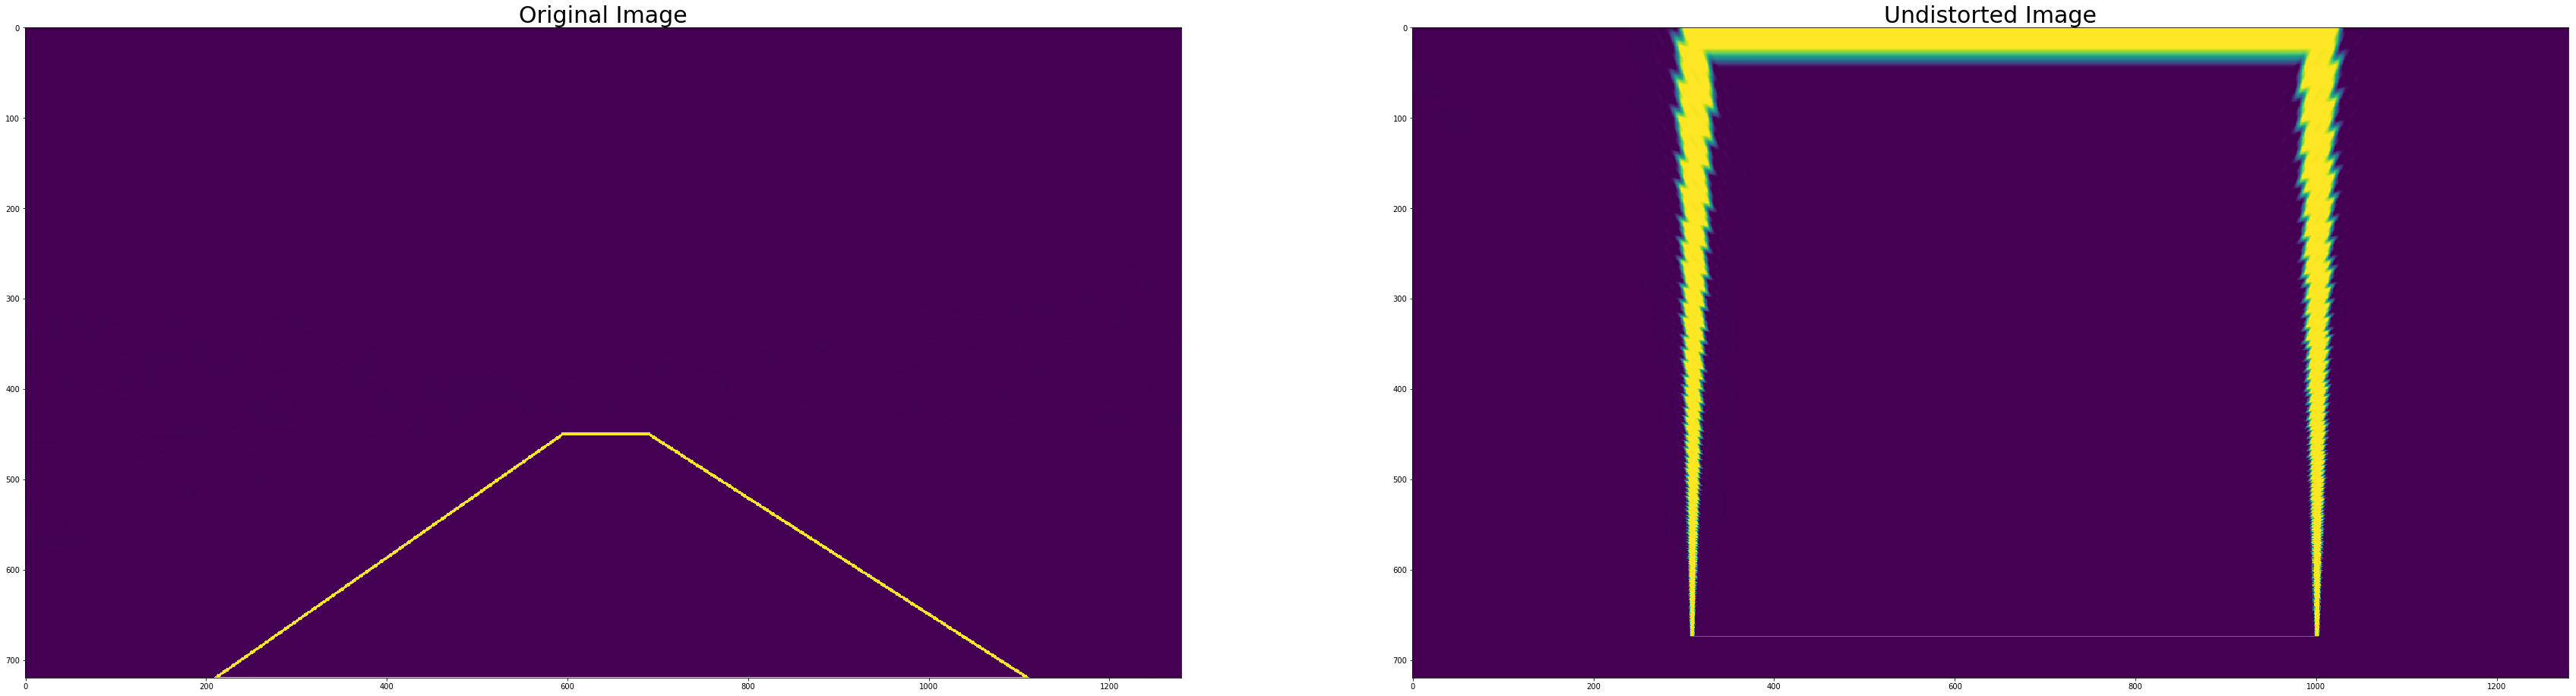

In [11]:
warp_lines = np.copy(before_warped)

cv2.polylines(warp_lines, np.int32([pipeline.lane_points]), True, (255, 0, 0), 2)

warped_lines = pipeline._warp_image(warp_lines)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,30))
ax1.imshow(warp_lines)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_lines)
ax2.set_title('Undistorted Image', fontsize=30)

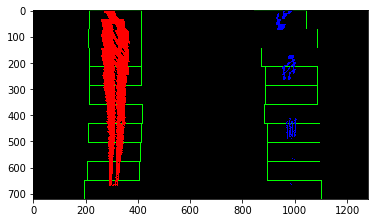

In [12]:
from src.road import Road

road = Road()

road.margin = 100
road.minpix = 50
road.n_windows = 10

plt.imshow(road.process(thresholded_warped_image))

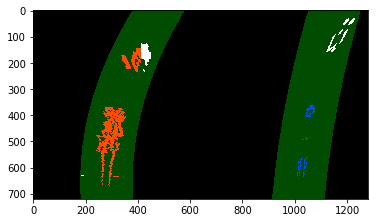

In [13]:
distorted_image2 = cv2.cvtColor(cv2.imread('test_images/test5.jpg'), cv2.COLOR_BGR2RGB)
thresholded_warped_image2, undistorted_2 = pipeline.process(distorted_image2)
plt.imshow(road.process(thresholded_warped_image2))

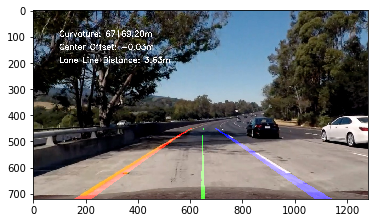

In [14]:
projected_lane = pipeline.project_lane(undistorted_2, thresholded_warped_image2, road.lane)
plt.imshow(projected_lane)

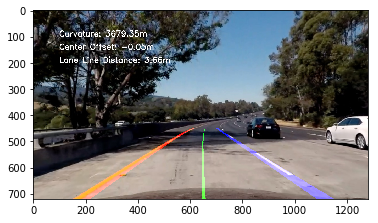

In [15]:
a, b = pipeline.process(undistorted_2)
p = road.process(a)
plt.imshow(pipeline.project_lane(b, a, road.lane))

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    warped_image, undistorted = pipeline.process(image)
    lane_image = road.process(warped_image)
    lane = pipeline.project_lane(image, warped_image, road.lane)
    
    top_row = np.hstack([image, pipeline._color_pipeline(image)])
    bottom_row = np.hstack([lane_image, lane])
    
    out_image =  np.vstack([top_row, bottom_row])
    
    return cv2.resize(out_image, (1280, 720))

In [18]:
white_output = 'output_movie/test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, threads=100)

t:   0%|          | 2/1260 [00:00<01:17, 16.28it/s, now=None]

Moviepy - Building video output_movie/test_video.mp4.
Moviepy - Writing video output_movie/test_video.mp4



Moviepy - Done !
Moviepy - video ready output_movie/test_video.mp4
CPU times: user 8min 19s, sys: 28.3 s, total: 8min 47s
Wall time: 2min 32s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))